In the following notebook, I have developed models for predicting the gender of a person based on an image.

The initial sections are dedicated to configuring the environment. The sections labeled *Loading the data* and *Preparing the first model* represent the initial approaches developed over the past few weeks. The subsequent sections (*Second approach*) utilize a different training and validation set, where the training set was split to increase the number of samples in the validation set. This was done to enhance the representativeness of the validation set, as I found the initially provided 1000 samples to be insufficient for validating the models. This adjustment resulted in improved results.

# GPU Acceleration

Checks if the computer has any GPU avaliable.

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-16 01:21:49.061380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:21:49.097467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:21:49.098251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# If using collab

Following cell mounts your google drive into the collab enviroment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


For this notebook, I upload the dataset zip files into a folder in my drive called *datasets* . 

In [ ]:
%cd /content/drive/MyDrive/datasets/
!ls

Once uploaded, you can unzip the files using the following cells.

In [ ]:
# For test set 
!unzip faces_dataset_test.zip
# For train set (it takes around 15 mins but only needs to be executed once)
!unzip faces_dataset_train.zip

You can use the following cells to check that everything has been decompresed correctly. I just check that the *metadata.json* file exists in the decompressed folders.

In [ ]:
%cd /content/drive/MyDrive/datasets/faces_dataset_train/
%ls | grep metadata
%cd /content/drive/MyDrive/datasets/faces_dataset_test/
%ls | grep metadata

In [ ]:
!ls

faces_dataset_test	faces_dataset_train
faces_dataset_test.zip	faces_dataset_train.zip


# Setting paths

### Execute this cell if you are using collab with the corresponding paths:

In [ ]:
# Dataset path
from os import listdir
import os.path

PATH = '/content/drive/MyDrive/Datasets/faces_dataset_train/'
PATH_TEST = '/content/drive/MyDrive/Datasets/faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Or if you are using a local enviroment, use your local paths:

In [3]:
# Dataset path
from os import listdir
import os.path

PATH = 'faces_dataset_train/'
PATH_TEST = 'faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

# Loading the data

### Metadata access

Accesing the metadata.json file

In [ ]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

The following enviroment variable is just to skip some errors that occurs in a Mac enviroment

In [ ]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Functions to process the data (image size scaled from 200x200 to 64x64)

In [ ]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 64
img_width = 64

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [ ]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

Rescaling input

In [ ]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

Applying stratification

Following code counts the number of samples of each class

In [ ]:
import numpy as np

labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
class_counts = np.unique(labels, return_counts=True)
total = 0
for c, count in zip(class_counts[0], class_counts[1]):
    total += count
    print(f"Class {c} --> {count}")

Class 0 --> 74253
Class 1 --> 52612


In [ ]:
# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


In [ ]:
print(len(ds_test_transform))

1000


Define batches

In [ ]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# Preparing the first model

A first simple model is constructed now to have an starting point in terms of complexity and performance. The model is constructed using the Functional API to build the Model class. 

- Input feature map has a shape of 32x32 with 3 color channels (depth). 
- Input is processed with a combination of Conv2D layers with increasing number of filters and MaxPooling layers to reduce dimensionality. 
- For Conv2D layers, a fixed kernel size of 3 was used and ReLu as activation function (only positive values).
- At last, a Flatten() layer output is sended to an output Dense layer with 1 neuron to learn the threshold to classify on Male or Female following a sigmoid activation function mapping.
- For this first approach, no regularization techniques had been applied.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(64,64,3))
x = layers.Conv2D(filters=32, kernel_size = 3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size = 3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size = 3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       7385

For a first approach, 5 epochs are used just to study the evolution of the model during training.

In [ ]:
num_epochs = 10

The Adam optimizer was chosen as a default approach for his adaptative nature. For loss function, BinaryCrossentropy loss is the selected one for being a binary classification task. For this first approach, no *weighted_metrics* were used.  

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'],
              weighted_metrics = [])


In [ ]:
history = model.fit(ds_train_batch,
                    epochs=num_epochs,
                    validation_data=ds_test_batch)

Epoch 1/10
992/992 [==============================] - 6s 6ms/step - loss: 0.3625 - accuracy: 0.8446 - val_loss: 0.3462 - val_accuracy: 0.8640
Epoch 2/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2921 - accuracy: 0.8893 - val_loss: 0.3589 - val_accuracy: 0.8520
Epoch 3/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2751 - accuracy: 0.8970 - val_loss: 0.3214 - val_accuracy: 0.8670
Epoch 4/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2628 - accuracy: 0.9026 - val_loss: 0.3264 - val_accuracy: 0.8660
Epoch 5/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2516 - accuracy: 0.9064 - val_loss: 0.3368 - val_accuracy: 0.8600
Epoch 6/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2400 - accuracy: 0.9104 - val_loss: 0.3334 - val_accuracy: 0.8750
Epoch 7/10
992/992 [==============================] - 6s 6ms/step - loss: 0.2285 - accuracy: 0.9140 - val_loss: 0.3360 - val_accuracy: 0.8620
Epoch 

We are gonna create a models folder and save the models there.

In [ ]:
!mkdir models

/bin/bash: /home/mia1/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mkdir: no se puede crear el directorio «models»: El archivo ya existe


In [ ]:
# Save the model
model.save('models/first_model.h5')

The following code loads the model from the created folder:

In [ ]:
# Load the model
from tensorflow.keras.models import load_model
loaded_model = load_model('models/first_model.h5')

Plotting the results

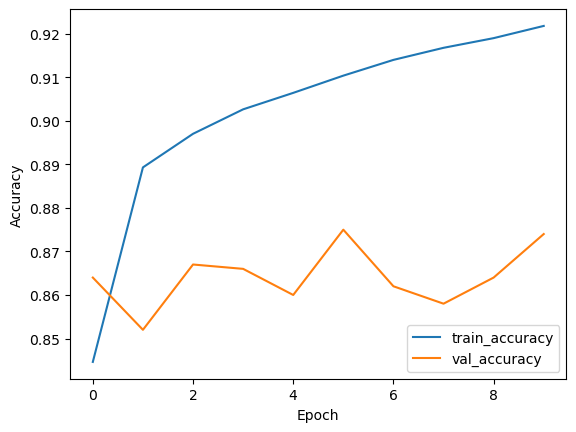

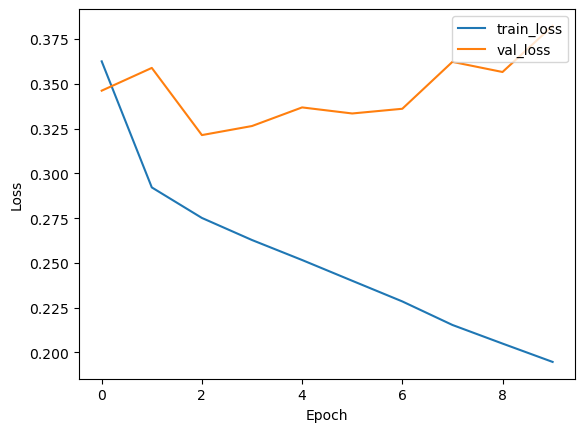

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Looking through the results, it seems that while the accuracy keeps converging the validation accuracy gets stucket growing and decreasing drawing peacks. On the other hand, the validation loss grows while the train loss slowly decreases, so it seems that the model is overfitting and not performing well on new cases.

## Testing other architectures

Along this section I have tried different model architectures in order to try to improve the model's performance and capacity to generalize. The idea was to first start with a very simple architecture, and see if more complex ones are worth in terms of performance. However, none of this architectures provides good results, so in the next section another approach was taken, studying first the data and making models with better results.

### Testing architecture 1

On this second approach I had tried to increment a little bit the complexity of the model and using regularization techniques to reduce overfitting. After each convolutional layer a batch normalization one is added before the pooling layer, and also dropout layers with 0.25 dropout rate were added in some of them. Also, another Conv2D block with 256 filters was added before flattening the output. Another changes comparing with the previous model were that two dense layers with corresponding dropouts were added at the end of the model before the output layer.

In [ ]:
from tensorflow import keras
from tensorflow.keras import *
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout


inputs = keras.Input(shape=(64,64,3))
x = layers.Conv2D(filters=64, kernel_size = 3, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=128, kernel_size = 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=256, kernel_size = 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64,activation="relu")(x)
x = Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

loss = BinaryCrossentropy()
num_epochs = 20

model.compile(optimizer=Adam(),
              loss=loss,
              metrics =['accuracy'])

# Train the model
history = model.fit(ds_train_batch,
                    epochs=num_epochs,
                    validation_data=ds_test_batch)

Epoch 1/20
992/992 [==============================] - 12s 12ms/step - loss: 0.4631 - accuracy: 0.7977 - val_loss: 0.3644 - val_accuracy: 0.8570
Epoch 2/20
992/992 [==============================] - 12s 12ms/step - loss: 0.3401 - accuracy: 0.8691 - val_loss: 0.3442 - val_accuracy: 0.8660
Epoch 3/20
992/992 [==============================] - 12s 12ms/step - loss: 0.3150 - accuracy: 0.8814 - val_loss: 0.3464 - val_accuracy: 0.8690
Epoch 4/20
992/992 [==============================] - 12s 12ms/step - loss: 0.3040 - accuracy: 0.8885 - val_loss: 0.3249 - val_accuracy: 0.8810
Epoch 5/20
992/992 [==============================] - 12s 12ms/step - loss: 0.2954 - accuracy: 0.8913 - val_loss: 0.3562 - val_accuracy: 0.8680
Epoch 6/20
992/992 [==============================] - 12s 12ms/step - loss: 0.2877 - accuracy: 0.8959 - val_loss: 0.3176 - val_accuracy: 0.8740
Epoch 7/20
992/992 [==============================] - 12s 12ms/step - loss: 0.2802 - accuracy: 0.8998 - val_loss: 0.3540 - val_accuracy:

In [ ]:
# Save the model
model.save('models/second_model.h5')

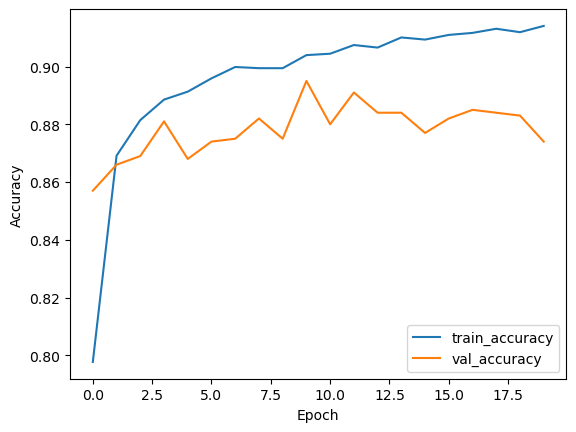

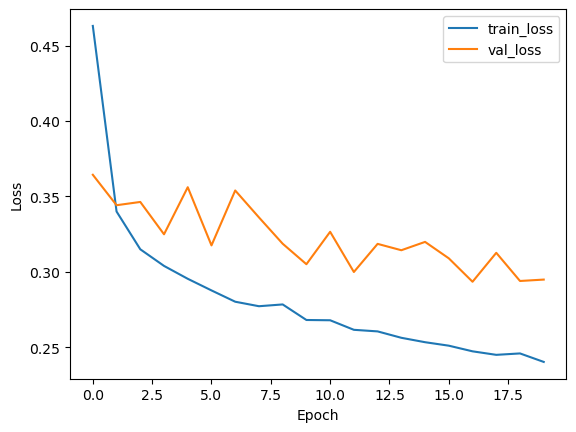

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

With a more complex model and with the double of epochs, we achieve little better results. Validation error seems to be a little less stable with regularization techniques, but it seems to be stucked on almost that previous range of values.

### Testing architecture 2

On this last approach, I just tried to copy a complex model. In this case I took AlexNet as reference and tried to build a similar model (a little simpler but keeping main concept)

Read all the data again (now using 128x128 rescaled images):

In [ ]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 128
img_width = 128

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

    
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))


# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))


batch_size = 32
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

<TakeDataset shapes: (), types: tf.string>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
/home/mia1/Documentos/DL/faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M
tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


Building the AlexNet based model:

- Input size 128x128
- First convolutional layers with higher kernel sizes and strides in order to detect larger features
- Padding added to most of the conv layers
- Dense layers at the end with dropout
- Conv2D and maxpooling combinations, batch normalization after each convolutional layer and dropout after dense ones.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

model = Sequential([
    Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(256, (5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
    Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
    Conv2D(256, (3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_9 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_10 (Bat  (None, 14, 14, 256)      1024      
 chNormalization)                                                
                                                      

Training:

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

loss = BinaryCrossentropy()
num_epochs = 10

model.compile(optimizer=Adam(),
              loss=loss,
              metrics =['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
history = model.fit(ds_train_batch,
                    epochs=num_epochs,
                    validation_data=ds_test_batch
                    callbacks=[early_stopping])

Epoch 1/10
3965/3965 [==============================] - 25s 6ms/step - loss: 0.4157 - accuracy: 0.8163 - val_loss: 0.3763 - val_accuracy: 0.8600
Epoch 2/10
3965/3965 [==============================] - 24s 6ms/step - loss: 0.3160 - accuracy: 0.8779 - val_loss: 0.3553 - val_accuracy: 0.8690
Epoch 3/10
3965/3965 [==============================] - 24s 6ms/step - loss: 0.2950 - accuracy: 0.8879 - val_loss: 0.3299 - val_accuracy: 0.8670
Epoch 4/10
3965/3965 [==============================] - 24s 6ms/step - loss: 0.2790 - accuracy: 0.8952 - val_loss: 0.3046 - val_accuracy: 0.8850
Epoch 5/10
3965/3965 [==============================] - 24s 6ms/step - loss: 0.2685 - accuracy: 0.9003 - val_loss: 0.3420 - val_accuracy: 0.8690
Epoch 6/10
3965/3965 [==============================] - 23s 6ms/step - loss: 0.2573 - accuracy: 0.9060 - val_loss: 0.3322 - val_accuracy: 0.8800
Epoch 7/10
3965/3965 [==============================] - 23s 6ms/step - loss: 0.2479 - accuracy: 0.9101 - val_loss: 0.3325 - val_ac

In [ ]:
# Save the model
model.save('models/third_model.h5')

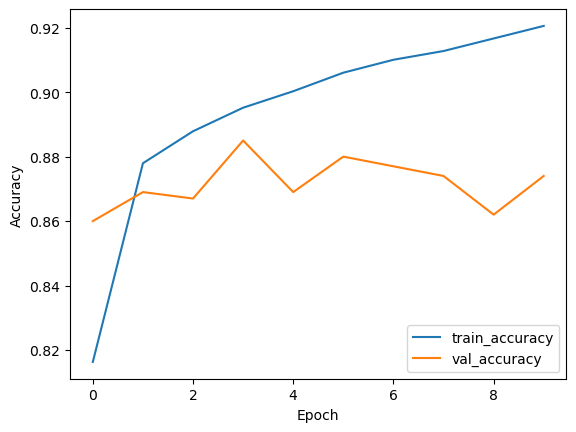

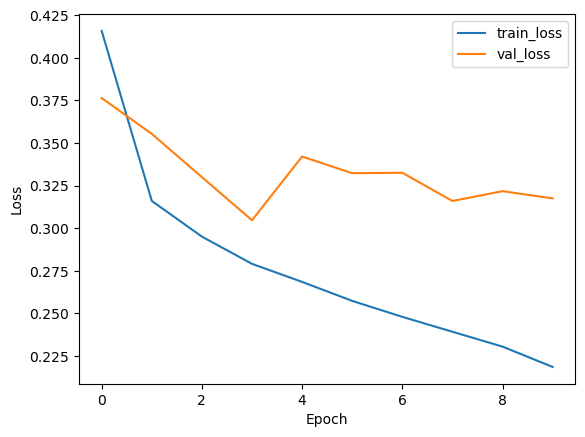

In [ ]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

It seems that the results for this much complex model are equal or even worse than with simpler models. Here, the difference between training and validation error is even more pronunciated. So in next section I tried a different approach.

# Second approach

For this second approach, I decided to take a look to the data. 
- There are around 120k images on the training set
- And only 1k on the new validation set

As models seemed to be stucked on that validation performance, I have suppossed that the data on the given test set is not sufficient or at least not enought representative. However, the training set is quite large, so I use a 20% split of the training set to create a new validation set. Also, I work here with 128x128 images (I have checked it also with the old data, but results remain similar. Its true that 64x64 and specially 32x32 are very small image sizes to fed the model with to try to detect gender on a face).

## Modified preprocessing

Read metadata again:

In [4]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


Defining height and width

In [5]:
# Size at which images will be processed
img_height = 128
img_width = 128

Splitting training set into train and validation (Remember that above cell to define functions must be executed)

In [6]:
def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

In [7]:
import tensorflow as tf
from matplotlib import pyplot

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)

# Split in training and validation from training set
validation_percentage = 20

train_size = int((100 - validation_percentage) / 100.0 * len(train_ds))
validation_size = len(train_ds) - train_size

train_ds = train_ds.shuffle(len(train_ds)) # shuffle data
validation_ds = train_ds.take(validation_size).map(process_path) # take images of 20% of the dataset
train_ds = train_ds.skip(validation_size).map(process_path) # take images unless the other 20%

Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


2023-03-16 01:24:07.386402: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 01:24:07.388084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:24:07.388818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:24:07.389503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [ ]:
ds_train_transform = train_ds
ds_test_transform = validation_ds
print(train_metadata[0])

Rescaling input

In [9]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))


Stratification of the data:

In [10]:
# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


Checking train and validation sets:

In [11]:
print('Test set size: ' + str(len(ds_test_transform)))
print('Train set size: ' + str(len(ds_train_transform)))


Test set size: 25373
Train set size: 101492


Defyning batches:

In [12]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

# Training with modified data

Lets take a look on how this modifications affect the previously designed models

## TestingModel class

For convenience, I define a class (**TestingModel**) to define the seen architectures, compile, train, save and plot the model with a little less of repeated code.

Three architectures defined: 
- **basic** : first one seen, consisting on Conv2D-MaxPooling layers combinations
- **regularized** : second seen before, with regularization techniques
- **alexnet** : last seen, based on AlexNet

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt

class TestingModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = None
    
    def build(self, model_name):
        if model_name == 'basic':
            inputs = keras.Input(shape=self.input_shape)
            x = layers.Conv2D(filters=32, kernel_size = 3, activation="relu")(inputs)
            x = layers.MaxPooling2D(pool_size=2)(x)
            x = layers.Conv2D(filters=64, kernel_size = 3, activation="relu")(x)
            x = layers.MaxPooling2D(pool_size=2)(x)
            x = layers.Conv2D(filters=128, kernel_size = 3, activation="relu")(x)
            x = layers.Flatten()(x)

            outputs = layers.Dense(1, activation="sigmoid")(x)
            model = keras.Model(inputs=inputs, outputs=outputs)
        elif model_name == 'regularized':
            inputs = keras.Input(shape=self.input_shape)
            x = layers.Conv2D(filters=64, kernel_size = 3, activation="relu")(inputs)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D(pool_size=2)(x)
            x = layers.Dropout(0.25)(x)
            x = layers.Conv2D(filters=128, kernel_size = 3, activation="relu")(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D(pool_size=2)(x)
            x = layers.Dropout(0.25)(x)
            x = layers.Conv2D(filters=256, kernel_size = 3, activation="relu")(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D(pool_size=2)(x)

            x = layers.Flatten()(x)
            x = Dense(128,activation="relu")(x)
            x = Dropout(0.5)(x)
            x = Dense(64,activation="relu")(x)
            x = Dropout(0.5)(x)

            outputs = layers.Dense(1, activation="sigmoid")(x)
            model = keras.Model(inputs=inputs, outputs=outputs)
        elif model_name == 'alexnet':
            model = Sequential([
            Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(256, (5,5), strides=(1,1), activation='relu', padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
            Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
            Conv2D(256, (3,3), strides=(1,1), activation='relu', padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(3,3), strides=(2,2)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        else:
            raise ValueError('Invalid model name')

        self.model = model
        return model

    def train(self, train_ds, val_ds, epochs, optimizer, loss_fn, metrics, early_stopping=None):
            self.model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
            if early_stopping is not None:
                history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=early_stopping)
            else: 
                history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs)

            return history

    def summary(self):
        self.model.summary()

    def save(self,full_path):
        self.model.save(full_path)

    def plot(self,history):
        # Plot the results
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()

        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.show()

## Models training

The training of the models is showed below. 

- Adam optimizer is used. I test others but Adam is the one that gives better results
- Early Stopping with a patience of 5 epochs without increasing the validation loss is implemented on each model

In [14]:
tm = TestingModel((128,128,3))

In [15]:
epochs = 50
optimizer = Adam() # I tried other optimizers but Adam is the one that gives better results
loss = BinaryCrossentropy()
metrics = ['accuracy']

Training the <span style="color:tomato">**first model**</span> again with 50 epochs:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856 

2023-03-16 01:27:06.167917: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-03-16 01:27:07.591353: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 01:27:07.592171: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 01:27:07.592194: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-16 01:27:07.593034: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-16 01:27:07.593094: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-16 01:27:08.530642: I tensorflow/stream_executor/cuda/c

793/793 [==============================] - 18s 17ms/step - loss: 0.4074 - accuracy: 0.8147 - val_loss: 0.3202 - val_accuracy: 0.8715
Epoch 2/50
793/793 [==============================] - 14s 17ms/step - loss: 0.3132 - accuracy: 0.8767 - val_loss: 0.2948 - val_accuracy: 0.8909
Epoch 3/50
793/793 [==============================] - 13s 17ms/step - loss: 0.2871 - accuracy: 0.8913 - val_loss: 0.2859 - val_accuracy: 0.8794
Epoch 4/50
793/793 [==============================] - 13s 17ms/step - loss: 0.2735 - accuracy: 0.8980 - val_loss: 0.2571 - val_accuracy: 0.9042
Epoch 5/50
793/793 [==============================] - 13s 17ms/step - loss: 0.2631 - accuracy: 0.9018 - val_loss: 0.2539 - val_accuracy: 0.9025
Epoch 6/50
793/793 [==============================] - 13s 17ms/step - loss: 0.2524 - accuracy: 0.9048 - val_loss: 0.2424 - val_accuracy: 0.9137
Epoch 7/50
793/793 [==============================] - 13s 17ms/step - loss: 0.2436 - accuracy: 0.9062 - val_loss: 0.2235 - val_accuracy: 0.9204
Epo

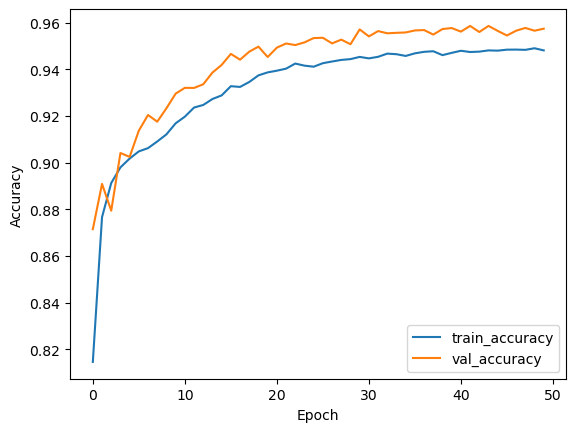

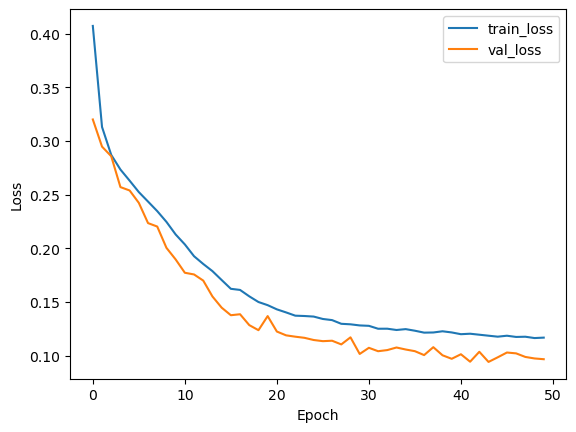

In [16]:
tm.build(model_name= 'basic')
tm.summary()
history = tm.train(ds_train_batch, ds_test_batch, epochs, optimizer, loss, metrics)
tm.plot(history)
tm.save('models/first_fixed.h5')


Training the <span style="color:tomato">*second model*</span> again (for this model i have used 20 epochs because of problems with cuda) :

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_9 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 128)       7385

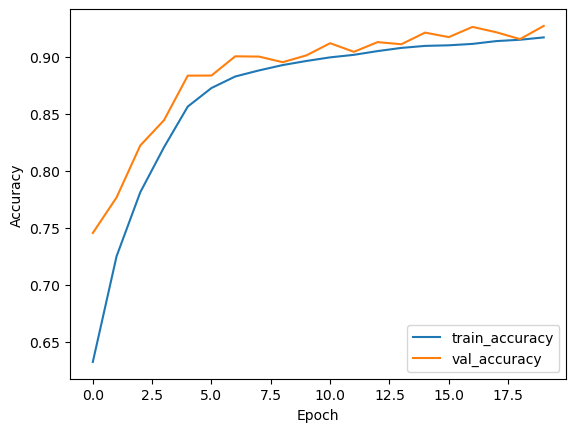

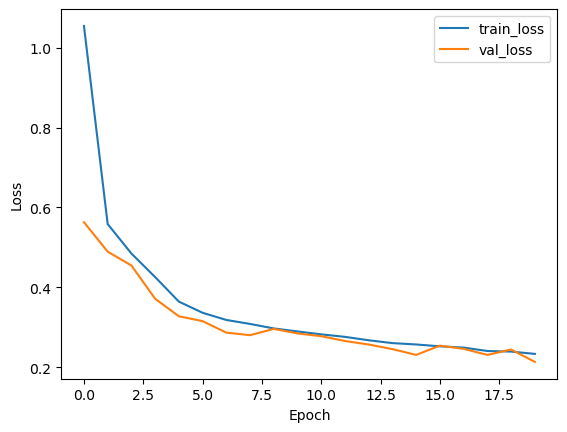

In [ ]:
tm.build(model_name= 'regularized')
tm.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = tm.train(ds_train_batch, ds_test_batch, epochs, optimizer, loss, metrics, early_stopping=early_stopping)
tm.plot(history)
tm.save('models/second_fixed.h5')


Training the <span style="color:tomato">*third model*</span> again:

With 20 epochs:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                        

2023-03-15 05:29:11.382114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-03-15 05:29:11.818657: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 05:29:11.819160: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 05:29:11.819168: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-15 05:29:11.819602: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 05:29:11.819632: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-15 05:29:12.461219: I tensorflow/stream_executor/cuda/c

793/793 [==============================] - 14s 15ms/step - loss: 0.4403 - accuracy: 0.7999 - val_loss: 0.3565 - val_accuracy: 0.8523
Epoch 2/20
793/793 [==============================] - 12s 15ms/step - loss: 0.3188 - accuracy: 0.8744 - val_loss: 0.3460 - val_accuracy: 0.8856
Epoch 3/20
793/793 [==============================] - 12s 15ms/step - loss: 0.2990 - accuracy: 0.8839 - val_loss: 0.2894 - val_accuracy: 0.8965
Epoch 4/20
793/793 [==============================] - 12s 15ms/step - loss: 0.2878 - accuracy: 0.8913 - val_loss: 0.3049 - val_accuracy: 0.8948
Epoch 5/20
793/793 [==============================] - 12s 15ms/step - loss: 0.2768 - accuracy: 0.8952 - val_loss: 0.3394 - val_accuracy: 0.9014
Epoch 6/20
793/793 [==============================] - 12s 15ms/step - loss: 0.2710 - accuracy: 0.8987 - val_loss: 0.3088 - val_accuracy: 0.9079
Epoch 7/20
793/793 [==============================] - 12s 15ms/step - loss: 0.2605 - accuracy: 0.9037 - val_loss: 0.2889 - val_accuracy: 0.9066
Epo

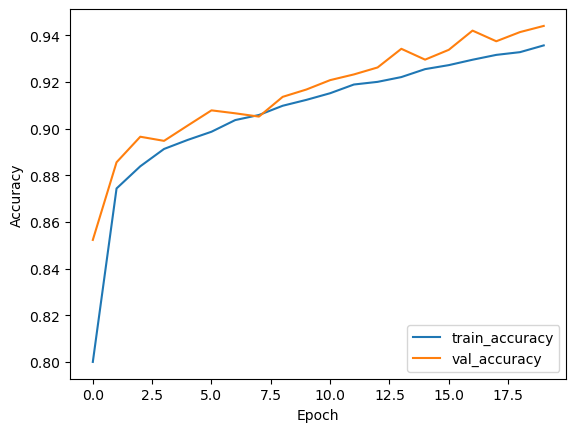

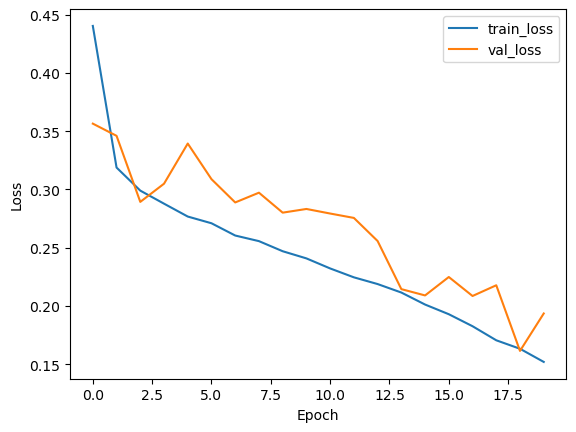

In [ ]:
tm.build(model_name= 'alexnet')
tm.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = tm.train(ds_train_batch, ds_test_batch, 20, optimizer, loss, metrics, early_stopping=early_stopping)
tm.plot(history)
tm.save('models/third_fixed.h5')


With 50 epochs:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                        

2023-03-15 20:37:37.973450: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-03-15 20:37:38.451568: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 20:37:38.451955: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 20:37:38.451964: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-15 20:37:38.452290: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-15 20:37:38.452317: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-15 20:37:39.030907: I tensorflow/stream_executor/cuda/c

793/793 [==============================] - 13s 14ms/step - loss: 0.4398 - accuracy: 0.7992 - val_loss: 0.3942 - val_accuracy: 0.8147
Epoch 2/50
793/793 [==============================] - 10s 13ms/step - loss: 0.3213 - accuracy: 0.8728 - val_loss: 0.3808 - val_accuracy: 0.8641
Epoch 3/50
793/793 [==============================] - 11s 13ms/step - loss: 0.2972 - accuracy: 0.8855 - val_loss: 0.3207 - val_accuracy: 0.8943
Epoch 4/50
793/793 [==============================] - 11s 13ms/step - loss: 0.2852 - accuracy: 0.8906 - val_loss: 0.3375 - val_accuracy: 0.8653
Epoch 5/50
793/793 [==============================] - 11s 13ms/step - loss: 0.2776 - accuracy: 0.8941 - val_loss: 0.2926 - val_accuracy: 0.9023
Epoch 6/50
793/793 [==============================] - 11s 13ms/step - loss: 0.2684 - accuracy: 0.8997 - val_loss: 0.2700 - val_accuracy: 0.9086
Epoch 7/50
793/793 [==============================] - 11s 13ms/step - loss: 0.2618 - accuracy: 0.9020 - val_loss: 0.2730 - val_accuracy: 0.9110
Epo

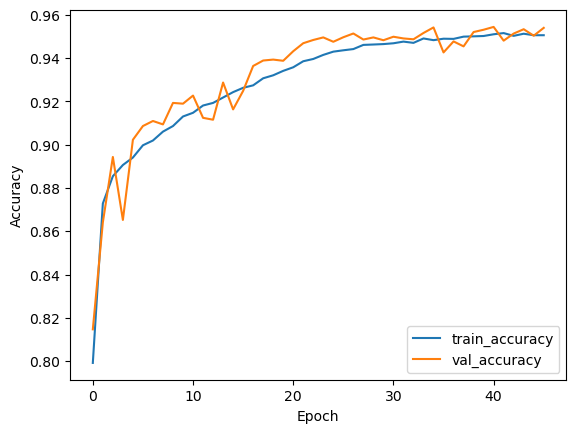

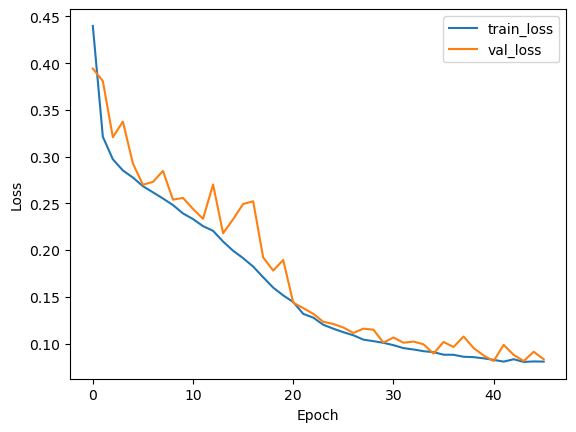

In [ ]:
tm.build(model_name= 'alexnet')
tm.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = tm.train(ds_train_batch, ds_test_batch, 50, keras.optimizers.Adam(), loss, metrics, early_stopping=early_stopping)

tm.plot(history)
tm.save('models/alex50.h5')


By taking a look to the new trained models, it can be see that there is not a huge difference between them (in this case, I cannot train the second one for 50 epochs without crashing the jupyter kernel, but the accuracy on validation was around 94% on one try around the 47 epoch). The models were all saved for possible future use.

# Conclussions

Two aproachs were followed during the present work trying to achieve a good accuracy for a model on the task of predicting gender of a face from an image. While on the second approach splitting the training set to get a new validation set the results were much more accurate, it seems that there is not a huge difference between the most simpler model consisting only on a combination of convolutional layers and max pooling ones, and the most complex one, trying to imitate the AlexNet architecture. Both of them achieve more than 95% of accuracy on validation. Taking a look to the graphics, more epochs seem to not be significative on improving the model accuracy as it seems to be on a convergence process. This fact of more simpler models performing better on this task is common in the two approaches followed during the work, with and without the larger validation set. Another variations of this models were also tested and results remained similar. However, maybe the future work can be focus on amplify the base data. A good starting point can be the second testing architecture with data generators, trying to have more data to fit the model to try to improve generalization capabilities.

To summarize; at the very end it seems that the most simpler solution to the problem is, in this case,, the most effective to solve it. 



